#Hate Speech Detection with AraBERT and HuggingFace
In this assignment, we will be exploring the application of the AraBERT model specifically for the task of hate speech detection. We will use the AJGT Sentiment Analysis dataset from K. M. Alomari, H. M. ElSherif, and K. Shaalan, “Arabic tweets sentimental analysis using machine learning,” in Proceedings of the International Conference on Industrial, Engineering and Other Applications of Applied Intelligent Systems, pp. 602–610, Montreal, Canada, June 2017.


# Check which GPU we have

In [62]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Thu Dec 28 11:26:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              33W /  70W |   3957MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

##Installing Prerequisites

In [63]:
!pip install transformers[torch]
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

fatal: destination path 'arabert' already exists and is not an empty directory.


#Reading Data
We will rely on the following libraries for training and evaluation:

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [65]:
!git clone https://github.com/komari6/Arabic-twitter-corpus-AJGT.git

fatal: destination path 'Arabic-twitter-corpus-AJGT' already exists and is not an empty directory.


**Question 1:** Read the dataset and arrange the columns name using the set variables:

In [66]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

dataset = pd.read_excel("Arabic-twitter-corpus-AJGT/AJGT.xlsx").rename(columns={'Feed': DATA_COLUMN, 'Sentiment': LABEL_COLUMN})
dataset

,ID,text,label
0,1,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,Positive
1,2,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,Negative
2,3,كله رائع بجد ربنا يكرمك,Positive
3,4,لسانك قذر يا قمامه,Negative
4,5,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,Negative
...,...,...,...
1795,1796,يلعن شرف خواتك,Negative
1796,1797,يلعنك نذل وكلب,Negative
1797,1798,يمتاز الاردن بتنوع السياحه فيه فتنقسم السياحه ...,Positive
1798,1799,ينور عليك ويكثر من امثالك,Positive


**Question 2**: Split the data into training and testing (80-20)

In [67]:
data_train, data_test = train_test_split(dataset, train_size=0.8, random_state=42)

**Question 3:** Plot the distribution of lengths of sentences in both training and test set. Extract the max_len value to be used later:

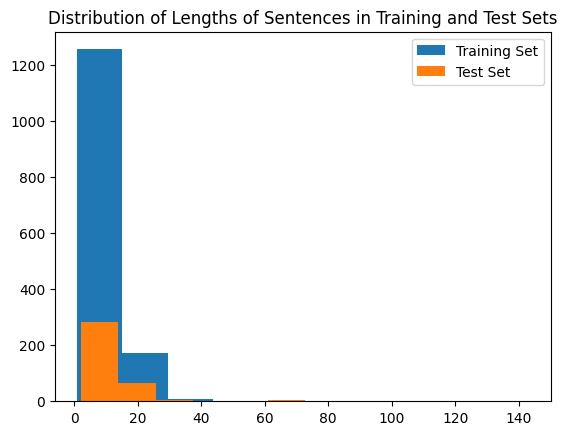

In [68]:
train_sentence_length = data_train["text"].apply(lambda x: len(x.split()))
test_sentence_length = data_test["text"].apply(lambda x: len(x.split()))

plt.hist(train_sentence_length, label="Training Set")
plt.hist(test_sentence_length, label="Test Set")
plt.title("Distribution of Lengths of Sentences in Training and Test Sets")
plt.legend();

In [69]:
max_len = max(train_sentence_length.max(), test_sentence_length.max())
max_len

143

We can conclude that the max_len can be chosen to be ___.

#Training Requirements

Let's start by creating the dataset needed for training and testing, we will use the Dataset class from pytorch as our base class.

For tokenization, we will be using the autotokenizer from HuggingFace.

In [70]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers.data.processors.utils import InputFeatures
from transformers import AutoTokenizer

#define the Dataset class
class SADataset(Dataset):
  def __init__(self, texts, labels, model_name, max_len, label_map):
    #hold the text and reviews inside the dataset class
    self.texts = texts
    self.labels = labels
    self.label_map = label_map
    self.tokenizer_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_len = max_len

  def __len__(self):
    #returns the length of the dataset
    return len(self.texts)

  def __getitem__(self, item):
    # Select the example based on the item ID
    text = str(self.texts[item])
    label = self.labels[item]

    input_dict = self.tokenizer(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding = 'max_length',
          truncation= True
      )

    return InputFeatures(input_ids=input_dict["input_ids"],
                         token_type_ids=input_dict['token_type_ids'],
                         attention_mask=input_dict["attention_mask"],
                         label=self.label_map[self.labels[item]])

**Question 4:** Define the evaluation metrics that we will need, including `accuracy_score`, `f1_score`, `precision_score` and `recall_score` from sklearn.

In [71]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def compute_metrics(pred):
  preds = np.argmax(pred.predictions, axis=1)
  assert len(preds) == len(pred.label_ids)

  labels = pred.label_ids

  acc = accuracy_score(labels, preds)
  macro_f1 = f1_score(labels, preds, average='macro')
  macro_f1_pos_neg = f1_score(labels, preds, average='macro', labels=["Positive", "Negative"])
  macro_precision = precision_score(labels, preds, average='macro')
  macro_recall = recall_score(labels, preds, average='macro')


  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

## Preprocess the dataset
Let's start by defining the AraBERT preprocessor:

In [72]:
from arabert.preprocess import ArabertPreprocessor

model_name = 'aubmindlab/bert-base-arabertv02'
arabert_prep = ArabertPreprocessor(model_name)

**Question 5:** Apply preprocessing for the text column using the arabert preprocessor:

In [73]:
data_train["text"] = data_train["text"].apply(lambda x: arabert_prep.preprocess(x))
data_test["text"] = data_test["text"].apply(lambda x: arabert_prep.preprocess(x))

Let's extract the label to id map:

In [74]:
label_list = list(data_test[LABEL_COLUMN].unique())
label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

{'Negative': 0, 'Positive': 1}


**Question 6:** Create the train and test SADataset:

In [75]:
train_dataset = SADataset(
    texts = data_train["text"].tolist(),
    labels = data_train["label"].tolist(),
    model_name = model_name,
    max_len = max_len,
    label_map = label_map
)

test_dataset = SADataset(
    texts = data_test["text"].tolist(),
    labels = data_test["label"].tolist(),
    model_name = model_name,
    max_len = max_len,
    label_map = label_map
)

# Setup the HuggingFace trainer

We will be using the `bert-base-arabertv02` from HuggingFace models by Antoun et Al (2020). We can choose other Arabic BERT models by just changing the path here from `https://huggingface.co/models`.

In [76]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can now set up the training arguments, you can more information from https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [77]:
from transformers import Trainer , TrainingArguments

training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 4,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_macro_f1',
    greater_is_better = True,
    seed = 42
  )

In [78]:
training_args.__dict__

{'output_dir': './train',
 'overwrite_output_dir': False,
 'do_train': False,
 'do_eval': True,
 'do_predict': False,
 'evaluation_strategy': <IntervalStrategy.EPOCH: 'epoch'>,
 'prediction_loss_only': False,
 'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 16,
 'per_gpu_train_batch_size': None,
 'per_gpu_eval_batch_size': None,
 'gradient_accumulation_steps': 2,
 'eval_accumulation_steps': None,
 'eval_delay': 0,
 'learning_rate': 5e-05,
 'weight_decay': 0.0,
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_epsilon': 1e-08,
 'max_grad_norm': 1.0,
 'num_train_epochs': 4,
 'max_steps': -1,
 'lr_scheduler_type': <SchedulerType.LINEAR: 'linear'>,
 'warmup_ratio': 0.0,
 'warmup_steps': 0,
 'log_level': 'passive',
 'log_level_replica': 'warning',
 'log_on_each_node': True,
 'logging_dir': './train/runs/Dec28_11-26-45_6eca16a5913b',
 'logging_strategy': <IntervalStrategy.STEPS: 'steps'>,
 'logging_first_step': False,
 'logging_steps': 500,
 'logging_nan_inf_filter': True,
 

**Question:** Initialize the Trainer and start training:

In [79]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy
1,No log,0.193956,0.938796,0.000000,0.938702,0.940988,0.938889
2,No log,0.170179,0.947104,0.000000,0.946640,0.948761,0.947222
3,No log,0.169567,0.949845,0.000000,0.949275,0.950948,0.950000
4,No log,0.158066,0.963685,0.000000,0.963886,0.963498,0.963889


/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this be

TrainOutput(global_step=180, training_loss=0.14014109505547417, metrics={'train_runtime': 108.5388, 'train_samples_per_second': 53.069, 'train_steps_per_second': 1.658, 'total_flos': 423279910310400.0, 'train_loss': 0.14014109505547417, 'epoch': 4.0})

#  Saving the best model

Before saving the model, let's change the label2id in the config file, and get the id to label map.

In [80]:
trainer.model.config.label2id = label_map
inv_label_map = { v:k for k, v in label_map.items()}
trainer.model.config.id2label = inv_label_map

In [81]:
#save the model in the folder
trainer.save_model("best_sa_model")
test_dataset.tokenizer.save_pretrained("best_sa_model")

('best_sa_model/tokenizer_config.json',
 'best_sa_model/special_tokens_map.json',
 'best_sa_model/vocab.txt',
 'best_sa_model/added_tokens.json',
 'best_sa_model/tokenizer.json')

# Loading the model for inference
We can use HuggingFace pipelines to load the model for inference:

In [82]:
from transformers import pipeline
pipe = pipeline(
        "sentiment-analysis",
        model = "best_sa_model",
        device=0, # set device to 0 for CUDA
        )

In [83]:
pipe("انا لا احبك")

[{'label': 'Negative', 'score': 0.9814018607139587}]

In [84]:
pipe("انا احبك")

[{'label': 'Positive', 'score': 0.9966804385185242}]